```python
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
```

# Setup Dask

In [3]:
import dask

dask.config.set({'temporary_directory': '~/dask_tmp_dir'})

from distributed import Client, progress

client = Client('172.17.0.2:8786')

client.restart()

# 3 Versions of Preprocessing Text

1. Bare Token: Sans grammer, sans semantics

```python
def token_cleaner(text):
    text = strip_multiple_whitespaces(text)
    text = remove_stopwords(text)
    text = strip_numeric(text) 
    text = strip_non_alphanum(text)
    text = strip_punctuation(text)
    text = strip_short(text, minsize=3)
    text = [ tok.lemma_.lower().strip() for tok in nlp(text, disable=['tagger', 'parser', 'ner']) ]
    text = [ tok for tok in text if tok not in SYMBOLS and tok not in STOPLIST ]
    return ' '.join(text)
```

2. Lemmas: Retain grammar and semantcis

```python
def token_cleaner(text):
    text = strip_multiple_whitespaces(text)
    text = strip_non_alphanum(text)
    text = strip_punctuation(text)
    text = strip_short(text, minsize=3) # optional
    text = [ tok.lemma_.lower().strip() for tok in nlp(text, disable=['tagger', 'parser', 'ner']) ]
    text = [ tok for tok in text if tok not in SYMBOLS ]
    return ' '.join(text)
```

3. Clean Text: Remove non-text only

```python
def token_cleaner(text):
    text = strip_multiple_whitespaces(text)
    text = strip_non_alphanum(text)
    text = strip_punctuation(text)
    text = strip_short(text, minsize=3) # optional
    text = [ tok.text.lower().strip() for tok in nlp(text, disable=['tagger', 'parser', 'ner']) ]
    text = [ tok for tok in text if tok not in SYMBOLS ]
    return ' '.join(text)
```

### SpaCy Trick nlp()

```python
def doc_to_spans(list_of_texts, join_string=' ||| '):
    all_docs = nlp(' ||| '.join(list_of_texts))
    split_inds = [i for i, token in enumerate(all_docs) if token.text == '|||'] + [len(all_docs)]
    new_docs = [all_docs[(i + 1 if i > 0 else i):j] for i, j in zip([0] + split_inds[:-1], split_inds)]
    return new_docs 
```

In [ ]:
import nltk
nltk.download('stopwords')

In [13]:
!python3 -m spacy download en_core_web_sm

    100% |################################| 11.1MB 94.7MB/s 
  Running setup.py install for en-core-web-sm ... done
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [1]:
import pandas as pd
import base64
import string
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]
import re
import spacy
nlp = spacy.load('en_core_web_sm')
from nltk.corpus import stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS 
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_numeric
from gensim.parsing.preprocessing import strip_non_alphanum, strip_short, strip_multiple_whitespaces

In [9]:
def token_cleaner(text):
    text = strip_multiple_whitespaces(text)
    text = remove_stopwords(text)
    text = strip_numeric(text) 
    text = strip_non_alphanum(text)
    text = strip_punctuation(text)
    text = strip_short(text, minsize=3)
    text = [ tok.lemma_.lower().strip() for tok in nlp(text, disable=['tagger', 'parser', 'ner']) ]
    text = [ tok for tok in text if tok not in SYMBOLS and tok not in STOPLIST ]
    return ' '.join(text)

In [10]:
import pandas as pd
import numpy as np
train_raw = pd.read_csv('kaggle_train.csv', dtype={'sentences': str})
train_raw.head()

,sentences,sentiment,id
0,"béart and berling are both superb , while hupp...",1,0
1,not only a coming-of-age story and cautionary ...,1,1
2,"at the end of the movie , my 6-year-old nephew...",1,2
3,"even if you can't pronounce "" gyro "" correctly...",1,3
4,an immensely entertaining look at some of the ...,1,4


In [11]:
train_raw['sentences'] = train_raw['sentences'].apply(token_cleaner)

In [12]:
train_raw.head()
del train_raw['id']

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_raw['sentences'], 
                                                    train_raw['sentiment'], 
                                                    random_state=42, 
                                                    shuffle=True)

In [15]:
# Standalone Vectoriser

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
vectorizer_tfidf = TfidfVectorizer(sublinear_tf=True, max_df=0.5)

In [17]:
X_train, X_test = vectorizer_tfidf.fit_transform(X_train), vectorizer_tfidf.transform(X_test)

# Dask GLM and GridSearch

In [20]:
!pip install dask-ml[complete]   # install all optional dependencies

  Using cached https://files.pythonhosted.org/packages/da/a4/3a54ca439a8d07d5582e076344cf27a3b0c77e0b63bee4824eb8fec3201b/dask_ml-0.12.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8d/c6/b28f5cada2aca31018a8bb210065f9b6a3174d25a80a9961c7bd3e831c3e/numba-0.43.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/cb/ee/36c6e0e7b51e08406e5c3bb036f35adb77bd0a89335437b2e6f03c948f1a/dask_glm-0.2.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/89/79/429ecef45fd5e4504f7474d4c3c3c4668c267be3370e4c2fd33e61506833/multipledispatch-0.6.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/00/a5/6cd58713aacf16fc8ef801e3020894a1faba7710c19c047c3e9582081b20/dask_tensorflow-0.0.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/6a/49/7e10686647f741bd9c8918b0decdb94135b542fe372ca1100739b8529503/xgboost-0.82-py2.py3-none-manylinux1_x86_64.whl
  Using cached http

In [71]:
import pandas as pd
import dask.array as da
import dask.dataframe as dd

from dask import persist, compute
from dask_glm.estimators import LogisticRegression

In [72]:
X_train, y_train, X_test, y_test = persist(X_train, y_train, X_test, y_test)

In [73]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

In [95]:
parameters = {
    'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True),
    'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (5,),
    'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__n_iter': [1000],
    'clf__max_iter': (10, 50, 80),
    'clf__loss': ['log']
}

```python
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(CountVectorizer(),
                         TfidfTransformer(),
                         SGDClassifier())
 
pipe = make_pipeline(
    CategoricalEncoder({"VendorID": [1, 2],
                        "payment_type": [1, 2, 3, 4, 5]}),
    DummyEncoder(),
    StandardScaler(columns=['passenger_count', 'trip_distance', 'fare_amount']),
    LogisticRegression(fit_intercept=False)
)
```

In [87]:
from dask_ml.model_selection import GridSearchCV, RandomizedSearchCV

In [96]:
#clf = GridSearchCV(pipeline, param_grid=parameters, cv=5, n_jobs=-1)
clf = RandomizedSearchCV(pipeline, param_distributions=parameters, cv=5, n_iter=50, n_jobs=-1)

In [97]:
clf.fit(X_train, y_train)

RandomizedSearchCV(cache_cv=True, cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
          iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'vect__max_features': (None, 5000, 10000, 50000), 'vect__ngram_range': ((1, 1), (1, 2)), 'tfidf__norm': ('l1', 'l2'), 'clf__max_iter': (10, 50, 80), 'clf__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'clf__penalty': ('l2', 'elasticnet'), 'clf__n_iter': [1000], 'clf__loss': ['log']},
          random_state=None, refit=True, return_train_score='warn',
          scheduler=None, scoring=None)

In [98]:
print("Best score: %0.3f" % clf.best_score_)
print("Best parameters set:")
best_parameters = clf.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.746
Best parameters set:
	clf__alpha: 0.001
	clf__loss: 'log'
	clf__max_iter: 50
	clf__n_iter: 1000
	clf__penalty: 'l2'
	tfidf__norm: 'l2'
	vect__max_features: 10000
	vect__ngram_range: (1, 1)


In [99]:
print(f'accuracy: {metrics.accuracy_score(y_test, clf.predict(X_test))}')
print()
print(f'F1-score: {metrics.f1_score(y_test, clf.predict(X_test))}')

accuracy: 0.7454289732770746

F1-score: 0.7430194036914339


# Dask Joblib

```python
import dask_ml.joblib  # registers joblib plugin
from dask.distributed import Client

#client = Client(processes=False)             # create local cluster
client = Client("scheduler-address:8786")  # or connect to remote cluster

from joblib import Parallel, parallel_backend
import time

# Embarrassingly Parallel
from math import sqrt
[sqrt(i ** 2) for i in range(10)]
from joblib import Parallel, delayed
Parallel(n_jobs=2)(delayed(sqrt)(i ** 2) for i in range(10))

from joblib import parallel_backend
with parallel_backend('threading', n_jobs=2):
    Parallel()(delayed(sqrt)(i ** 2) for i in range(10))

def long_running_function(i):
    time.sleep(.1)
    return i

with joblib.parallel_backend('dask'):
    joblib.Parallel(verbose=100)(
        joblib.delayed(long_running_function)(i)
        for i in range(10))

# DASK-JOBLIB-SKL
with parallel_backend('dask'):
    # normal Joblib code

import dask_ml.joblib  # registers joblib plugin
# Scikit-learn bundles joblib, so you need to import from
# `sklearn.externals.joblib` instead of `joblib` directly
from sklearn.externals.joblib import parallel_backend
from sklearn.datasets import load_digits
from sklearn.grid_search import RandomizedSearchCV
from sklearn.svm import SVC
import numpy as np

digits = load_digits()

param_space = {
    'C': np.logspace(-6, 6, 13),
    'gamma': np.logspace(-8, 8, 17),
    'tol': np.logspace(-4, -1, 4),
    'class_weight': [None, 'balanced'],
}

model = SVC(kernel='rbf')
search = RandomizedSearchCV(model, param_space, cv=3, n_iter=50, verbose=10)

with parallel_backend('dask'):
    search.fit(digits.data, digits.target)
    
# Serialize the training data only once to each worker
with parallel_backend('dask', scatter=[digits.data, digits.target]):
    search.fit(digits.data, digits.target)
```

### TQDM

```python
from tqdm import tqdm

for i in tqdm(range(10)):
    [i*2 for j in range(100)]
```

# Benchmark Pythonic Parallel Libs

```python
import multiprocessing as mp
from joblib import Parallel, delayed
import numpy as np
pool = mp.Pool(processes=num_cores)
import concurrent.features


def my_sum(n): return sum(range(n))

num_cores = mp.cpu_count()

# With no parallelization, 13.6 seconds per loop:
%%timeit -n 3 -r 3
for i in range(48):
    my_sum(10000000)

#With joblib, 736ms per loop:
%%timeit -n 3 -r 3
results = Parallel(n_jobs=num_cores)(delayed(my_sum)(10000000) for i in range(num_cores))

#With multiprocessing package, 815ms per loop:
%%timeit -n 3 -r 3
results = [pool.apply_async(my_sum,args=(10000000,)) for i in range(num_cores)]
output = [p.get() for p in results]

#With concurrent.futures, 1.29s per loop:
%%timeit -n 3 -r 3
with concurrent.futures.ProcessPoolExecutor() as executor:
    output = executor.map(my_sum,[10000000]*num_cores)
```

# SKL Benchmark

In [26]:
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

In [22]:
from sklearn.externals.joblib import parallel_backend

In [ ]:
from joblib import Parallel, parallel_backend

In [23]:
import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

In [24]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))
    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

In [53]:
results = []
with parallel_backend('dask'):
    for clf, name in (
            (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
            (Perceptron(max_iter=50, tol=1e-3), "Perceptron"),
            (PassiveAggressiveClassifier(max_iter=50, tol=1e-3),
             "Passive-Aggressive"),
            (KNeighborsClassifier(n_neighbors=10), "kNN"),
            (RandomForestClassifier(n_estimators=100), "Random forest")):
        print('=' * 80)
        print(name)
        results.append(benchmark(clf))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.01)
train time: 0.052s
test time:  0.001s
accuracy:   0.730
dimensionality: 10874
density: 1.000000
confusion matrix:
[[769 282]
 [294 788]]

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=50, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=0.001,
      validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.009s
test time:  0.001s
accuracy:   0.676
dimensionality: 10874
density: 0.788302
confusion matrix:
[[729 322]
 [369 713]]

Passive-Aggressive
_________________________________________

In [54]:
with parallel_backend('dask'):
    for penalty in ["l2", "l1"]:
        print('=' * 80)
        print("%s penalty" % penalty.upper())
        # Train Liblinear model
        results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                           tol=1e-3)))
        # Train SGD model
        results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                               penalty=penalty)))

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
train time: 0.040s
test time:  0.001s
accuracy:   0.729
dimensionality: 10874
density: 1.000000
confusion matrix:
[[761 290]
 [287 795]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.036s
test time:  0.001s
accuracy:   0.7

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


In [55]:
with parallel_backend('dask'):
    # Train SGD with Elastic Net penalty
    print('=' * 80)
    print("Elastic-Net penalty")
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty="elasticnet")))
    
    # Train NearestCentroid without threshold
    print('=' * 80)
    print("NearestCentroid (aka Rocchio classifier)")
    results.append(benchmark(NearestCentroid()))
    
    # Train sparse Naive Bayes classifiers
    print('=' * 80)
    print("Naive Bayes")
    results.append(benchmark(MultinomialNB(alpha=.01)))
    results.append(benchmark(BernoulliNB(alpha=.01)))
    results.append(benchmark(ComplementNB(alpha=.1)))
    
    print('=' * 80)
    print("LinearSVC with L1-based feature selection")
    # The smaller C, the stronger the regularization.
    # The more regularization, the more sparsity.
    results.append(benchmark(Pipeline([
      ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                      tol=1e-3))),
      ('classification', LinearSVC(penalty="l2"))])))

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.071s
test time:  0.001s
accuracy:   0.733
dimensionality: 10874
density: 0.789590
confusion matrix:
[[766 285]
 [285 797]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.005s
test time:  0.054s
accuracy:   0.710
confusion matrix:
[[741 310]
 [308 774]]

Naive Bayes
_________________________________________

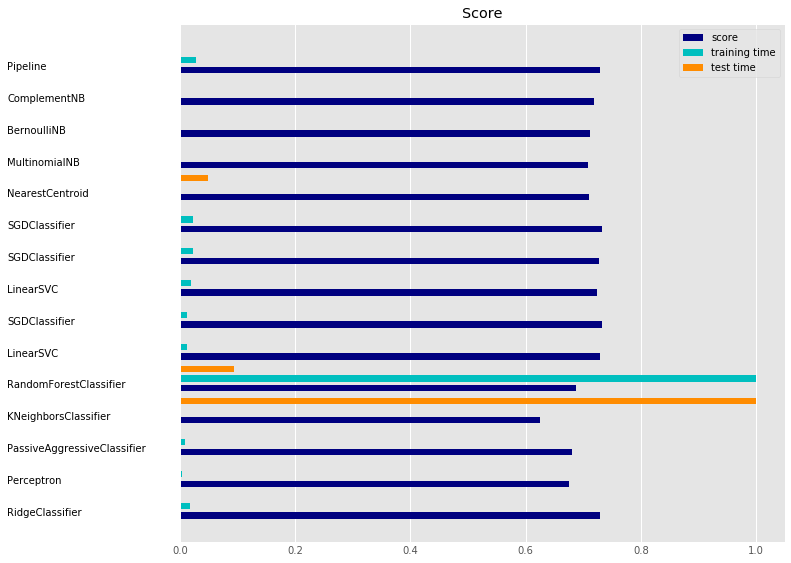

In [62]:
# make some plots

from copy import copy

results_plt = copy(results)

indices = np.arange(len(results_plt))

results_plt = [[x[i] for x in results_plt] for i in range(4)]

clf_names, score, training_time, test_time = results_plt
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.style.use('ggplot')

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)


plt.show()

# Ensemble

In [101]:
import xgboost as xgb

In [106]:
# Create full pipeline
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', xgb.XGBClassifier(objective='binary:logistic')),
])


# Create the parameter grid
xgb_param_grid = {
    'clf__learning_rate': np.arange(.05, 1, .05),
    'clf__max_depth': np.arange(3, 10, 1),
    'clf__n_estimators': np.arange(50, 200, 50),
    'clf__gamma': [0.5, 1, 1.5, 2, 5],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
}

      #silent': ['1'],
      #'colsample': [0.9],
      #'colsample_bytree': [0.6, 0.8, 1.0],
      #'eta': [0.1],
      #'max_depth': [3, 4, 5, 8],
      #'min_child_weight': [1, 5, 10],
      #'subsample': [0.6, 0.8, 1.0],
      #'gamma': [0.5, 1, 1.5, 2, 5],
      #'n_estimators': [20, 50, 100],
      #'reg_alpha': [0.3, 0.5, 0.8],
      #'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
      #'scale_pos_weight': 1,


# Perform RandomizedSearchCV
randomized_roc_auc = RandomizedSearchCV(estimator=pipeline,
                                        param_distributions=xgb_param_grid,
                                        n_iter=20, n_jobs=-1, scoring='roc_auc', cv=5,random_state=42)

# Fit the estimator
randomized_roc_auc.fit(X_train, y_train)

# Compute metrics
print(randomized_roc_auc.best_score_)
print(randomized_roc_auc.best_estimator_)

0.7379588888890926
Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...eg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1.0))])


In [107]:
print("Best score: %0.3f" % randomized_roc_auc.best_score_)
print("Best parameters set:")
best_parameters = randomized_roc_auc.best_estimator_.get_params()
for param_name in sorted(xgb_param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
print(f'accuracy: {metrics.accuracy_score(y_test, randomized_roc_auc.predict(X_test))}')
print()
print(f'F1-score: {metrics.f1_score(y_test, randomized_roc_auc.predict(X_test))}')

Best score: 0.738
Best parameters set:
	clf__colsample_bytree: 0.6
	clf__gamma: 0.5
	clf__learning_rate: 0.7000000000000001
	clf__max_depth: 7
	clf__n_estimators: 100
	clf__subsample: 1.0
accuracy: 0.6910454758556024

F1-score: 0.6848397895743663
